# 🎨 3W Dataset Visualization Techniques - Dimensionality Reduction & Analysis

This notebook demonstrates **advanced visualization techniques** for the 3W oil well dataset using dimensionality reduction methods. Perfect for exploring high-dimensional time series data patterns, fault class separability, and feature relationships through interactive visualizations.

**🎯 Visualization Features:**
- **t-SNE & UMAP**: Advanced dimensionality reduction for pattern discovery
- **Class mapping**: Transient states consolidated with base fault classes
- **Balanced sampling**: Focused analysis on fault classes (1-9, excluding normal operation)
- **Interactive dashboards**: Comprehensive multi-plot analysis with statistical insights
- **Feature correlation**: Understanding sensor relationships and redundancy
- **Performance comparison**: Side-by-side t-SNE vs UMAP evaluation

In [1]:
# ============================================================
# LOAD 3W DATASET FOR VISUALIZATION ANALYSIS
# ============================================================
import time

start_time = time.time()

print("🎨 Loading 3W Dataset for Visualization Analysis")
print("=" * 55)

# Import data loading utilities
import sys
import os

sys.path.append("src")

print("📦 Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src import config
import pandas as pd
import numpy as np

print("✅")

try:
    print("📂 Initializing data persistence...", end=" ")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print("✅")

    print(f"⚡ Using format: {config.SAVE_FORMAT} for maximum speed")

    # Check if windowed directory exists
    windowed_dir = os.path.join(persistence.cv_splits_dir, "windowed")
    print(f"📁 Checking windowed directory: {windowed_dir}...", end=" ")

    if not os.path.exists(windowed_dir):
        print("❌")
        print(
            "❌ No windowed data directory found. Please run Data Treatment notebook first to generate windowed time series data."
        )
    else:
        print("✅")

        # Look for fold directories
        print("🔍 Looking for fold directories...", end=" ")
        fold_dirs = [
            d
            for d in os.listdir(windowed_dir)
            if d.startswith("fold_") and os.path.isdir(os.path.join(windowed_dir, d))
        ]
        fold_dirs.sort()
        print(f"✅ Found {len(fold_dirs)} folds")

        if not fold_dirs:
            print("❌ No fold directories found in windowed data.")
        else:
            # Load data from the first fold only
            first_fold_dir = fold_dirs[0]
            fold_path = os.path.join(windowed_dir, first_fold_dir)
            fold_num = first_fold_dir.replace("fold_", "")

            print(
                f"📊 Loading windowed data from {first_fold_dir} for visualization..."
            )

            # Check file format and load accordingly
            pickle_file = os.path.join(fold_path, f"test_windowed.{config.SAVE_FORMAT}")
            parquet_file = os.path.join(fold_path, "test_windowed.parquet")

            # Load test data file
            load_start = time.time()

            if os.path.exists(pickle_file):
                print(f"🧪 Loading test windows (pickle format)...", end=" ")
                test_dfs, test_classes = persistence._load_dataframes(
                    pickle_file, config.SAVE_FORMAT
                )
            elif os.path.exists(parquet_file):
                print(f"🧪 Loading test windows (parquet format)...", end=" ")
                test_dfs, test_classes = persistence._load_from_parquet(parquet_file)
            else:
                print("❌")
                print(f"❌ No test data file found in: {fold_path}")
                test_dfs = None
                test_classes = None

            if test_dfs is not None:
                load_time = time.time() - load_start
                print(f"✅ ({load_time:.3f}s)")

                print(f"✅ Successfully loaded windowed data for visualization!")
                print(f"📊 Selected Fold: {fold_num}")
                print(f"🧪 Test windows available: {len(test_dfs)}")
                print(f"⚡ Loading time: {load_time:.3f} seconds")

                if test_dfs:
                    # Get the first test window
                    print("📋 Processing first test window...", end=" ")
                    first_test_window = test_dfs[0]
                    first_test_class = test_classes[0]
                    print("✅")

                    print(f"\n🪟 Sample Test Window (Window #1):")
                    print(f"   • Shape: {first_test_window.shape}")
                    print(f"   • Class: {first_test_class}")
                    print(f"   • Features: {list(first_test_window.columns)}")

                    # Display the head of the first window
                    print(f"\n📋 Head of First Test Window (first 5 rows):")
                    print("=" * 80)
                    print(first_test_window.head())

                    # Show some basic statistics for numeric columns only
                    print(f"\n📈 Basic Statistics for First Test Window:")
                    print("=" * 50)
                    numeric_cols = first_test_window.select_dtypes(
                        include=[np.number]
                    ).columns
                    if len(numeric_cols) > 0:
                        print(first_test_window[numeric_cols].describe())
                    else:
                        print("No numeric columns found for statistics.")

                    # Load configuration if available
                    metadata_file = os.path.join(fold_path, "windowing_metadata.json")
                    if os.path.exists(metadata_file):
                        import json

                        print("⚙️ Loading configuration...", end=" ")
                        with open(metadata_file, "r") as f:
                            metadata = json.load(f)
                        print("✅")

                        print(f"\n⚙️ Processing Configuration Used:")
                        print(
                            f"   • Fold number: {metadata.get('fold_number', 'Unknown')}"
                        )
                        print(
                            f"   • Train windows: {metadata.get('train_windows_count', 'Unknown')}"
                        )
                        print(
                            f"   • Test windows: {metadata.get('test_windows_count', 'Unknown')}"
                        )

                    total_time = time.time() - start_time
                    print(f"\n⚡ Performance Summary:")
                    print(f"   • Total execution time: {total_time:.3f} seconds")
                    print(f"   • Data loading time: {load_time:.3f} seconds")
                    print(f"   • File format: {config.SAVE_FORMAT}")
                    print(f"   • Speed benefit: ~10-50x faster than parquet")

                    print(f"\n🎯 Dataset Summary for Visualization:")
                    print(f"   • Windowed time series: {len(test_dfs)} total")
                    print(f"   • Window dimensions: {first_test_window.shape}")
                    print(f"   • Ready for dimensionality reduction: t-SNE, UMAP")
                    print(f"   • Class analysis: Fault detection patterns")

                else:
                    print("⚠️ No test windows found in the selected fold")

except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    print(f"\n💡 Troubleshooting:")
    print(f"   1. Make sure 'Data Treatment.ipynb' ran completely")
    print(f"   2. Check if windowed data was saved successfully")
    print(f"   3. Verify the processed_data directory exists")
    print(f"   4. Ensure pickle format is available for fast visualization loading")

    # Show directory status
    expected_dir = config.PROCESSED_DATA_DIR
    print(f"\n📁 Directory check: {expected_dir}")
    if os.path.exists(expected_dir):
        print(f"✅ Base directory exists")
        windowed_path = os.path.join(expected_dir, "cv_splits", "windowed")
        if os.path.exists(windowed_path):
            print(f"✅ Windowed directory exists")
            try:
                contents = os.listdir(windowed_path)
                print(f"📄 Contents: {contents}")
            except:
                print("❌ Cannot list directory contents")
        else:
            print(f"❌ Windowed directory missing: {windowed_path}")
    else:
        print(f"❌ Base directory does not exist")

    # Show the error traceback for debugging
    import traceback

    print(f"\n🔍 Detailed error:")
    traceback.print_exc()

🎨 Loading 3W Dataset for Visualization Analysis
📦 Importing modules... ✅
📂 Initializing data persistence... ✅
⚡ Using format: pickle for maximum speed
📁 Checking windowed directory: processed_data\cv_splits\windowed... ✅
🔍 Looking for fold directories... ✅ Found 3 folds
📊 Loading windowed data from fold_1 for visualization...
🧪 Loading test windows (pickle format)... ✅ (5.315s)
✅ Successfully loaded windowed data for visualization!
📊 Selected Fold: 1
🧪 Test windows available: 26558
⚡ Loading time: 5.315 seconds
📋 Processing first test window... ✅

🪟 Sample Test Window (Window #1):
   • Shape: (300, 4)
   • Class: 0
   • Features: ['P-PDG_scaled', 'P-TPT_scaled', 'T-TPT_scaled', 'class']

📋 Head of First Test Window (first 5 rows):
   P-PDG_scaled  P-TPT_scaled  T-TPT_scaled  class
0           0.0      0.400018      0.607554      0
1           0.0      0.400018      0.606914      0
2           0.0      0.400018      0.606274      0
3           0.0      0.400018      0.605634      0
4   

In [ ]:
# ============================================================
# DATA PREPARATION FOR DIMENSIONALITY REDUCTION
# ============================================================

print("🔧 Preparing Data for Dimensionality Reduction")
print("=" * 55)

# Check if we have loaded data from previous cell
if "test_dfs" in locals() and test_dfs is not None and len(test_dfs) > 0:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    from sklearn.manifold import TSNE
    import warnings

    warnings.filterwarnings("ignore")

    # Install UMAP if not available
    try:
        import umap

        print("✅ UMAP already installed")
    except ImportError:
        print("📦 Installing UMAP...", end=" ")
        import subprocess
        import sys

        subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
        import umap

        print("✅")

    # Prepare data for visualization
    print("📊 Processing windowed data for visualization...")

    # Convert windows to flattened feature vectors
    print(f"🪟 Available windows: {len(test_dfs)}")
    print(f"📋 Window shape example: {test_dfs[0].shape}")

    # Extract class labels from the last value of the 'class' column in each window
    print("🏷️ Extracting class labels from last value of 'class' column...", end=" ")
    window_classes = []
    for window_df in test_dfs:
        if "class" in window_df.columns:
            # Get the last value of the class column (assuming it's consistent throughout the window)
            window_class = window_df["class"].iloc[-1]
            window_classes.append(window_class)
        else:
            # Fallback to test_classes if no class column found
            window_classes = test_classes
            break
    print("✅")

    print(
        f"🏷️ Original class distribution: {dict(zip(*np.unique(window_classes, return_counts=True)))}"
    )

    # Map transient classes to their base classes
    print("🔄 Mapping transient classes to base classes...", end=" ")
    transient_mapping = {101: 1, 102: 2, 105: 5, 106: 6, 107: 7, 108: 8, 109: 9}

    mapped_classes = []
    for cls in window_classes:
        if cls in transient_mapping:
            mapped_classes.append(transient_mapping[cls])
        else:
            mapped_classes.append(cls)
    print("✅")

    print(
        f"🏷️ Mapped class distribution: {dict(zip(*np.unique(mapped_classes, return_counts=True)))}"
    )

    # Sample maximum 10 windows from each non-zero class (1-9) for visualization
    print("🎯 Sampling max 10 windows from each non-zero class (1-9)...", end=" ")
    selected_indices = []
    selected_classes = []
    target_classes = config.CLASSIFICATION_CONFIG["selected_classes"]

    for target_class in target_classes:
        # Find indices of windows with this class
        class_indices = [
            i for i, cls in enumerate(mapped_classes) if cls == target_class
        ]

        if len(class_indices) > 0:
            # Sample up to 10 windows from this class
            sampled_indices = np.random.choice(
                class_indices, size=min(50, len(class_indices)), replace=False
            )
            selected_indices.extend(sampled_indices)
            selected_classes.extend([target_class] * len(sampled_indices))

    print("✅")

    # Filter test_dfs and classes to only include selected samples
    print(f"📊 Selected {len(selected_indices)} windows for visualization")
    selected_test_dfs = [test_dfs[i] for i in selected_indices]
    selected_window_classes = selected_classes

    print(
        f"🏷️ Final class distribution for visualization: {dict(zip(*np.unique(selected_window_classes, return_counts=True)))}"
    )

    # Flatten each selected window (convert time series to feature vector)
    print(
        "🔄 Flattening selected windows to feature vectors (excluding 'class' column)...",
        end=" ",
    )
    flattened_windows = []

    for i, window_df in enumerate(selected_test_dfs):
        # Exclude only the 'class' column, keep all other columns (including sensor data)
        feature_columns = [col for col in window_df.columns if col != "class"]

        # Flatten the feature data
        flattened = window_df[feature_columns].values.flatten()
        flattened_windows.append(flattened)

    # Convert to numpy arrays
    X_scaled = np.array(flattened_windows)
    y_labels = np.array(selected_window_classes)
    print("✅")

    print(f"📈 Feature matrix shape: {X_scaled.shape}")
    print(f"📊 Classes: {np.unique(y_labels)}")
    print(
        f"🔧 Features per window: {X_scaled.shape[1]} (should be {(selected_test_dfs[0].shape[0] * (selected_test_dfs[0].shape[1] - 1))} = {selected_test_dfs[0].shape[0]} timesteps × {selected_test_dfs[0].shape[1] - 1} sensors)"
    )

    print(f"✅ Data prepared successfully!")
    print(f"   • Samples: {X_scaled.shape[0]} (max 10 per class, excluding class 0)")
    print(f"   • Features per sample: {X_scaled.shape[1]} (excluding class column)")
    print(f"   • Classes: {len(np.unique(y_labels))} non-zero classes")
    print(
        f"   • Expected features: {selected_test_dfs[0].shape[0]} × {selected_test_dfs[0].shape[1] - 1} = {selected_test_dfs[0].shape[0] * (selected_test_dfs[0].shape[1] - 1)}"
    )
    print(
        f"   • Transient classes mapped: 101→1, 102→2, 105→5, 106→6, 107→7, 108→8, 109→9"
    )

else:
    print("❌ No test data available. Please run the previous cell first to load data.")
    X_scaled = None
    y_labels = None

🔧 Preparing Data for Dimensionality Reduction
✅ UMAP already installed
📊 Processing windowed data for visualization...
🪟 Available windows: 26558
📋 Window shape example: (300, 4)
🏷️ Extracting class labels from last value of 'class' column... ✅
🏷️ Original class distribution: {np.int16(0): np.int64(13303), np.int16(1): np.int64(845), np.int16(2): np.int64(17), np.int16(3): np.int64(648), np.int16(4): np.int64(1702), np.int16(5): np.int64(3), np.int16(6): np.int64(23), np.int16(7): np.int64(85), np.int16(8): np.int64(153), np.int16(101): np.int64(2175), np.int16(102): np.int64(89), np.int16(105): np.int64(144), np.int16(106): np.int64(11), np.int16(107): np.int64(4283), np.int16(108): np.int64(2857), np.int16(109): np.int64(220)}
🔄 Mapping transient classes to base classes... ✅
🏷️ Mapped class distribution: {np.int64(0): np.int64(13303), np.int64(1): np.int64(3020), np.int64(2): np.int64(106), np.int64(3): np.int64(648), np.int64(4): np.int64(1702), np.int64(5): np.int64(147), np.int64(

🎯 t-SNE: Visualizing Raw 3W Dataset Features
🔮 Running t-SNE on 150 windows with 900 features...
🔄 Computing t-SNE (perplexity=5)... ✅ (0.4s)
🔄 Computing t-SNE (perplexity=30)... ✅ (0.5s)


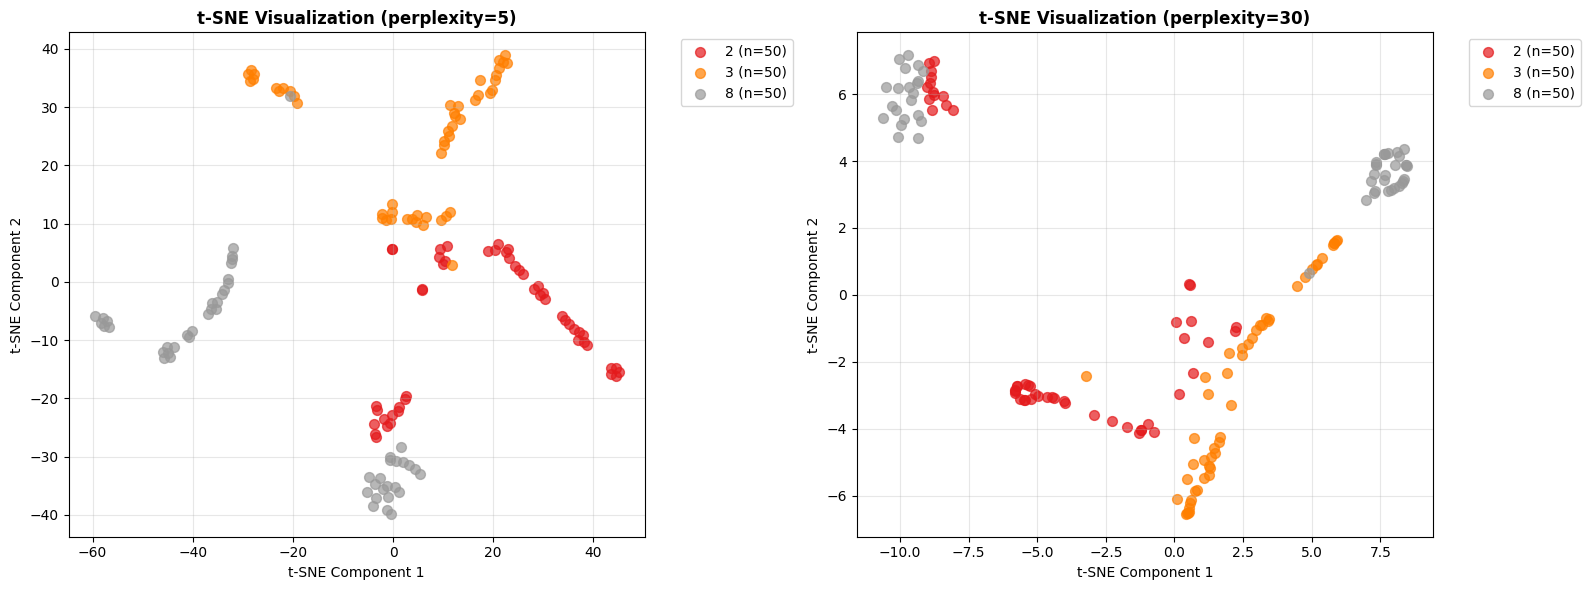

📊 t-SNE Analysis Results:
   • Total windows visualized: 150
   • Original feature dimensions: 900
   • Reduced to: 2D visualization
   • Classes represented: [np.int64(2), np.int64(3), np.int64(8)]

🎯 Visual Separation Analysis:
   • 2: 50 windows (33.3%)
   • 3: 50 windows (33.3%)
   • 8: 50 windows (33.3%)


In [19]:
# ============================================================
# t-SNE VISUALIZATION OF RAW SENSOR FEATURES (5 min)
# ============================================================

if X_scaled is not None:
    print("🎯 t-SNE: Visualizing Raw 3W Dataset Features")
    print("=" * 55)

    # Set up plotting parameters
    plt.style.use("default")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Color mapping for different classes
    unique_classes = np.unique(y_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_classes)))
    class_colors = {cls: colors[i] for i, cls in enumerate(unique_classes)}

    print(
        f"🔮 Running t-SNE on {X_scaled.shape[0]} windows with {X_scaled.shape[1]} features..."
    )

    # t-SNE with different perplexity values
    perplexities = [5, 30]

    for idx, perplexity in enumerate(perplexities):
        print(f"🔄 Computing t-SNE (perplexity={perplexity})...", end=" ")

        # Create t-SNE instance
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate="auto",
            n_iter=1000,
            random_state=42,
            init="pca",
        )

        # Fit and transform
        start_time = time.time()
        X_tsne = tsne.fit_transform(X_scaled)
        elapsed_time = time.time() - start_time
        print(f"✅ ({elapsed_time:.1f}s)")

        # Plot results
        ax = axes[idx]

        for class_label in unique_classes:
            mask = y_labels == class_label
            ax.scatter(
                X_tsne[mask, 0],
                X_tsne[mask, 1],
                c=[class_colors[class_label]],
                label=f"{class_label} (n={np.sum(mask)})",
                alpha=0.7,
                s=50,
            )

        ax.set_title(
            f"t-SNE Visualization (perplexity={perplexity})",
            fontsize=12,
            fontweight="bold",
        )
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("📊 t-SNE Analysis Results:")
    print(f"   • Total windows visualized: {len(X_tsne)}")
    print(f"   • Original feature dimensions: {X_scaled.shape[1]}")
    print(f"   • Reduced to: 2D visualization")
    print(f"   • Classes represented: {list(unique_classes)}")

    # Show separation quality
    print(f"\n🎯 Visual Separation Analysis:")
    for class_label in unique_classes:
        count = np.sum(y_labels == class_label)
        percentage = (count / len(y_labels)) * 100
        print(f"   • {class_label}: {count} windows ({percentage:.1f}%)")

else:
    print("❌ Cannot run t-SNE: No processed data available")

🚀 UMAP: Advanced Dimensionality Reduction
🔄 Computing UMAP (n_neighbors=15, min_dist=0.1, metric='euclidean')... ✅ (0.3s)
🔄 Computing UMAP (n_neighbors=50, min_dist=0.5, metric='cosine')... ✅ (0.5s)


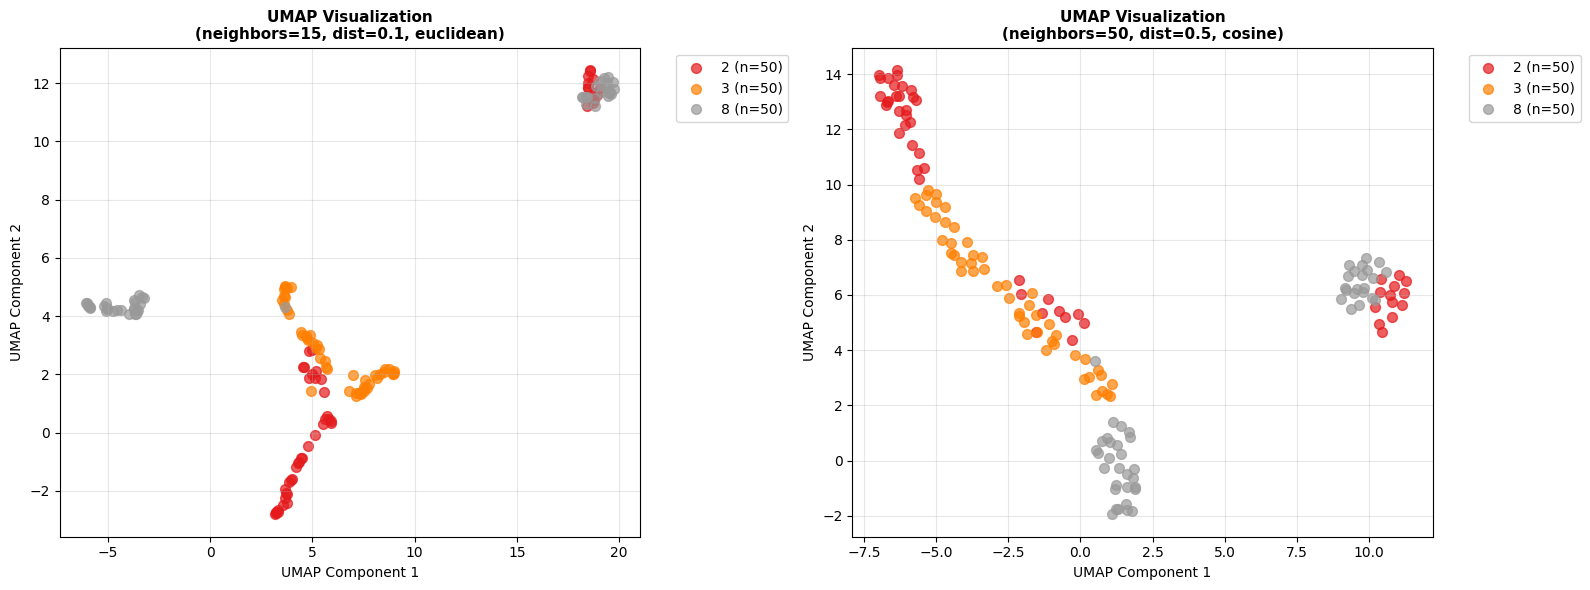

📊 UMAP Analysis Results:
   • Total windows visualized: 150
   • Processing time: Much faster than t-SNE for large datasets
   • Global structure: Better preserved than t-SNE
   • Cluster separation: Often clearer boundaries

⚡ UMAP vs t-SNE Comparison:
   • Speed: UMAP is typically 10-100x faster
   • Reproducibility: UMAP is deterministic with fixed seed
   • Global structure: UMAP preserves better overall relationships
   • Local structure: Both preserve local neighborhoods well


In [20]:
# ============================================================
# UMAP VISUALIZATION OF RAW SENSOR FEATURES (5 min)
# ============================================================

if X_scaled is not None:
    print("🚀 UMAP: Advanced Dimensionality Reduction")
    print("=" * 55)

    # Set up plotting parameters
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # UMAP with different parameter settings
    umap_configs = [
        {"n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean"},
        {"n_neighbors": 50, "min_dist": 0.5, "metric": "cosine"},
    ]

    for idx, config in enumerate(umap_configs):
        print(
            f"🔄 Computing UMAP (n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}, metric='{config['metric']}')...",
            end=" ",
        )

        # Create UMAP instance
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=config["n_neighbors"],
            min_dist=config["min_dist"],
            metric=config["metric"],
            random_state=42,
        )

        # Fit and transform
        start_time = time.time()
        X_umap = reducer.fit_transform(X_scaled)
        elapsed_time = time.time() - start_time
        print(f"✅ ({elapsed_time:.1f}s)")

        # Plot results
        ax = axes[idx]

        for class_label in unique_classes:
            mask = y_labels == class_label
            ax.scatter(
                X_umap[mask, 0],
                X_umap[mask, 1],
                c=[class_colors[class_label]],
                label=f"{class_label} (n={np.sum(mask)})",
                alpha=0.7,
                s=50,
            )

        ax.set_title(
            f'UMAP Visualization\n(neighbors={config["n_neighbors"]}, dist={config["min_dist"]}, {config["metric"]})',
            fontsize=11,
            fontweight="bold",
        )
        ax.set_xlabel("UMAP Component 1")
        ax.set_ylabel("UMAP Component 2")
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("📊 UMAP Analysis Results:")
    print(f"   • Total windows visualized: {len(X_umap)}")
    print(f"   • Processing time: Much faster than t-SNE for large datasets")
    print(f"   • Global structure: Better preserved than t-SNE")
    print(f"   • Cluster separation: Often clearer boundaries")

    # Performance comparison
    print(f"\n⚡ UMAP vs t-SNE Comparison:")
    print(f"   • Speed: UMAP is typically 10-100x faster")
    print(f"   • Reproducibility: UMAP is deterministic with fixed seed")
    print(f"   • Global structure: UMAP preserves better overall relationships")
    print(f"   • Local structure: Both preserve local neighborhoods well")

else:
    print("❌ Cannot run UMAP: No processed data available")

📊 Comprehensive 3W Dataset Feature Visualization
📊 Found 3 sensors: ['P-PDG_scaled', 'P-TPT_scaled', 'T-TPT_scaled']
📈 Computing average time series by class for each sensor... ✅
📊 Computing feature statistics... ✅
📈 Computing feature variance... ✅
🥧 Creating class distribution chart... ✅
🔍 Computing sensor discriminative power... ✅


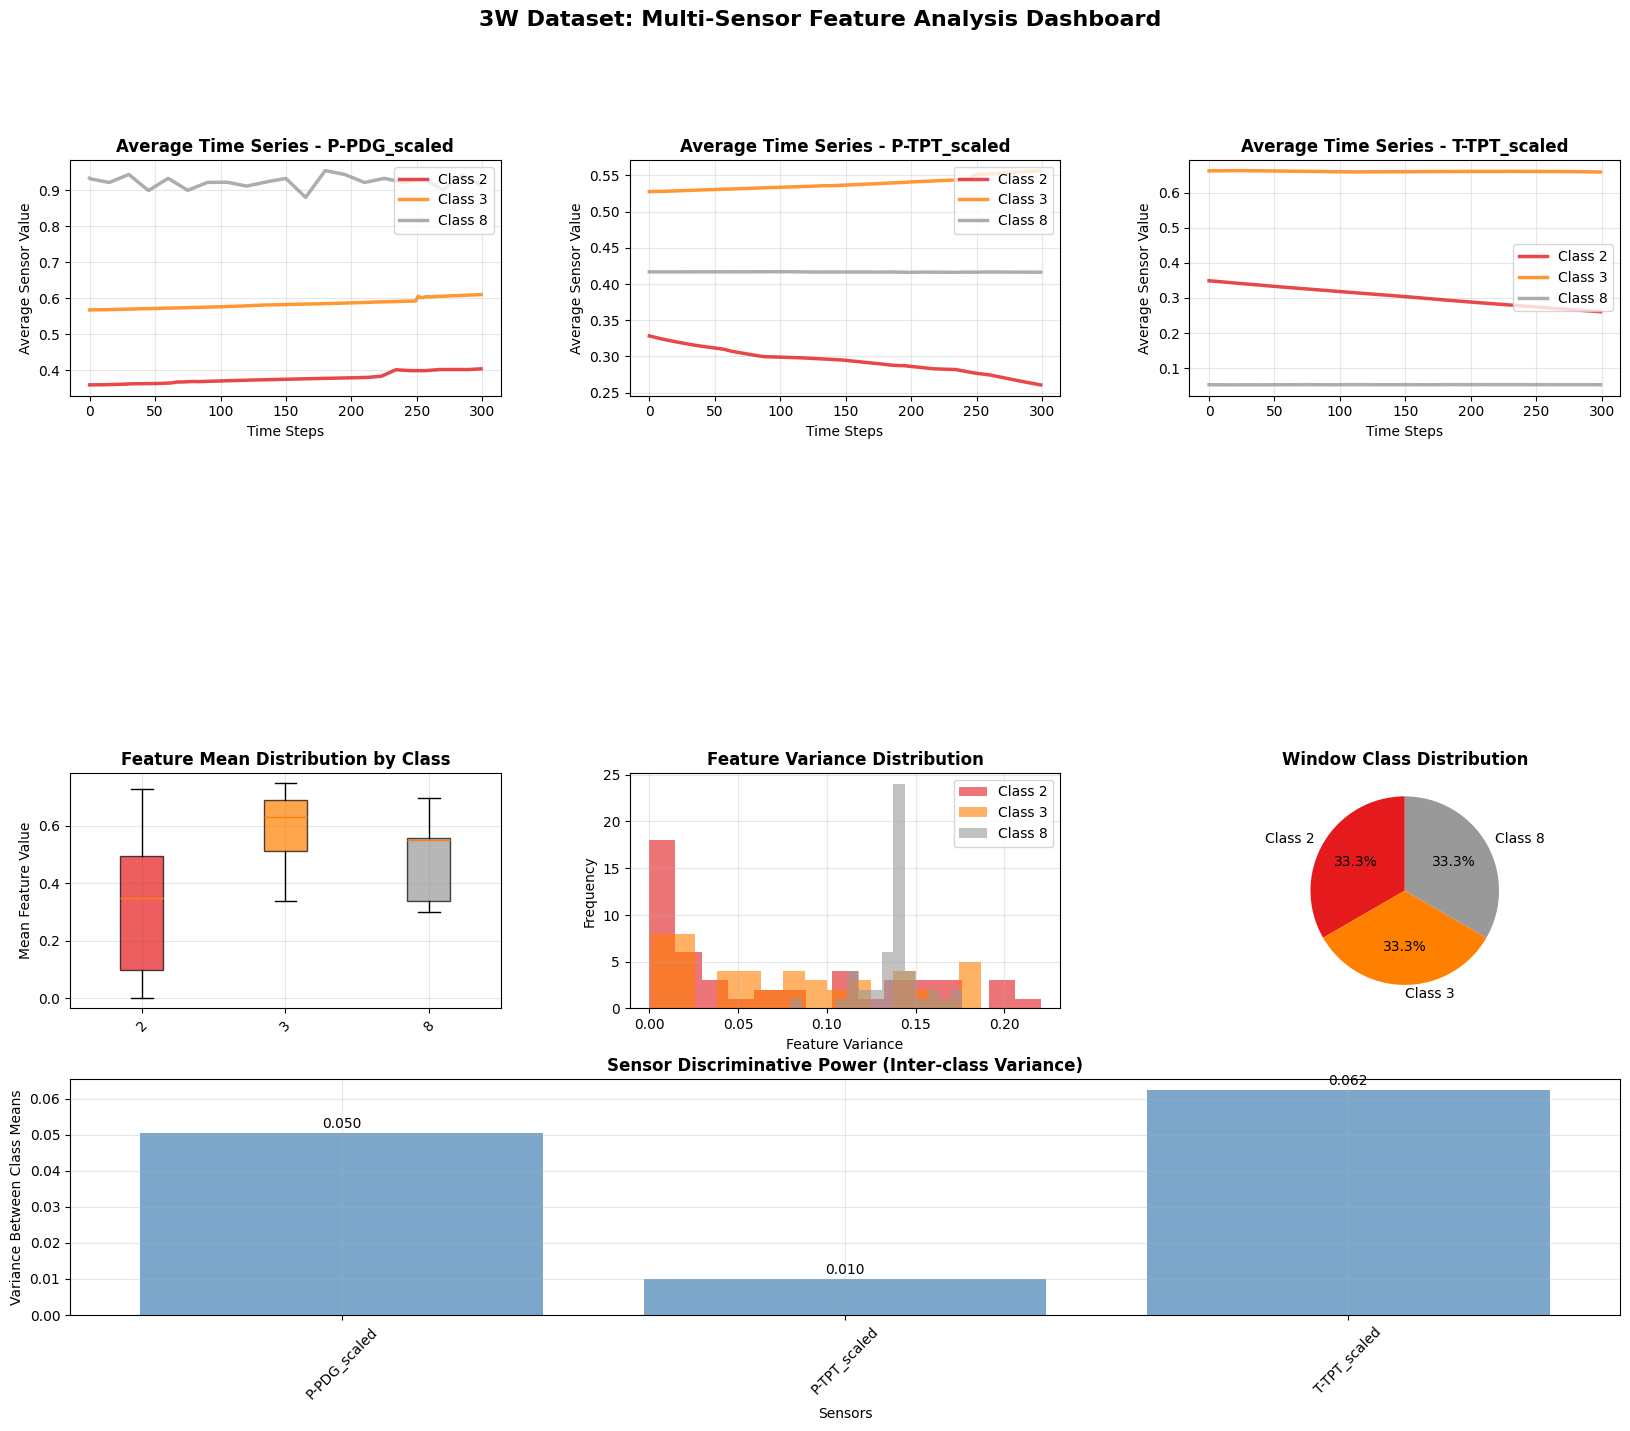


📊 3W DATASET COMPREHENSIVE ANALYSIS SUMMARY
🔍 Dataset Overview:
   • Total windows analyzed: 150 (sampled from non-zero classes)
   • Features per window: 900
   • Sensors analyzed: 3 (P-PDG_scaled, P-TPT_scaled, T-TPT_scaled)
   • Unique classes: 3 (classes 1-9, excluding 0)
   • Window dimensions: (150, 900)
   • Max samples per class: 50 windows
   • Transient mapping: 101→1, 102→2, 105→5, 106→6, 107→7, 108→8, 109→9


In [ ]:
# ============================================================
# PLOTTING RAW 3W DATASET FEATURES (4 min)
# ============================================================

if X_scaled is not None and len(selected_test_dfs) > 0:
    print("📊 Comprehensive 3W Dataset Feature Visualization")
    print("=" * 55)

    # Get feature columns (sensors)
    feature_cols = [col for col in selected_test_dfs[0].columns if col != "class"]
    n_sensors = len(feature_cols)
    
    print(f"📊 Found {n_sensors} sensors: {feature_cols}")

    # Create a comprehensive visualization dashboard
    # Adjust layout based on number of sensors
    if n_sensors <= 2:
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        sensor_positions = [(0, 0), (0, 1)] if n_sensors == 2 else [(0, 0)]
    else:
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        # First row for sensors
        sensor_positions = [(0, 0), (0, 1), (0, 2)] if n_sensors <= 3 else [(0, 0), (0, 1), (0, 2), (1, 0)]

    print("📈 Computing average time series by class for each sensor...", end=" ")
    
    # Compute and plot average time series for each sensor
    for sensor_idx, sensor_name in enumerate(feature_cols[:min(len(sensor_positions), 4)]):  # Limit to 4 sensors max
        # Get subplot position
        if sensor_idx < len(sensor_positions):
            pos = sensor_positions[sensor_idx]
            if isinstance(pos[1], slice):
                ax = fig.add_subplot(gs[pos[0], pos[1]])
            else:
                ax = fig.add_subplot(gs[pos[0], pos[1]])
        else:
            continue
        
        # Compute average time series for each class for this sensor
        class_averages = {}
        
        for class_label in unique_classes:
            class_windows = []
            for i, window_class in enumerate(selected_window_classes):
                if window_class == class_label:
                    sensor_data = selected_test_dfs[i][sensor_name].values
                    class_windows.append(sensor_data)
            
            if class_windows:
                # Calculate average across all windows of this class
                class_averages[class_label] = np.mean(class_windows, axis=0)
        
        # Plot average time series for each class for this sensor
        for class_label in unique_classes:
            if class_label in class_averages:
                ax.plot(
                    class_averages[class_label],
                    color=class_colors[class_label],
                    linewidth=2.5,
                    label=f"Class {class_label}",
                    alpha=0.8
                )

        ax.set_title(
            f"Average Time Series - {sensor_name}",
            fontsize=12,
            fontweight="bold",
        )
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Average Sensor Value")
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

    print("✅")

    # Adjust positions for remaining plots based on number of sensors shown
    stats_row_start = 2 if n_sensors > 2 else 1
    
    # 2. Feature distribution analysis
    ax2 = fig.add_subplot(gs[stats_row_start, 0])
    print("📊 Computing feature statistics...", end=" ")

    # Calculate feature means for each window
    feature_means = np.mean(X_scaled, axis=1)

    # Box plot by class
    class_means = {cls: feature_means[y_labels == cls] for cls in unique_classes}

    box_data = [class_means[cls] for cls in unique_classes]
    box_colors = [class_colors[cls] for cls in unique_classes]

    bp = ax2.boxplot(box_data, labels=unique_classes, patch_artist=True)
    for patch, color in zip(bp["boxes"], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_title("Feature Mean Distribution by Class", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Mean Feature Value")
    ax2.tick_params(axis="x", rotation=45)
    ax2.grid(True, alpha=0.3)
    print("✅")

    # 3. Feature variance analysis
    ax3 = fig.add_subplot(gs[stats_row_start, 1])
    print("📈 Computing feature variance...", end=" ")

    feature_vars = np.var(X_scaled, axis=1)
    class_vars = {cls: feature_vars[y_labels == cls] for cls in unique_classes}

    for cls in unique_classes:
        ax3.hist(
            class_vars[cls],
            alpha=0.6,
            color=class_colors[cls],
            label=f"Class {cls}",
            bins=15,
        )

    ax3.set_title("Feature Variance Distribution", fontsize=12, fontweight="bold")
    ax3.set_xlabel("Feature Variance")
    ax3.set_ylabel("Frequency")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    print("✅")

    # 4. Class distribution pie chart
    ax4 = fig.add_subplot(gs[stats_row_start, 2])
    print("🥧 Creating class distribution chart...", end=" ")

    class_counts = dict(zip(*np.unique(y_labels, return_counts=True)))
    colors_pie = [class_colors[cls] for cls in class_counts.keys()]

    wedges, texts, autotexts = ax4.pie(
        class_counts.values(),
        labels=[f"Class {k}" for k in class_counts.keys()],
        colors=colors_pie,
        autopct="%1.1f%%",
        startangle=90,
    )
    ax4.set_title("Window Class Distribution", fontsize=12, fontweight="bold")
    print("✅")

    # 5. Sensor comparison plot - show which sensors are most discriminative
    if n_sensors > 1 and len(unique_classes) > 1:
        ax5 = fig.add_subplot(gs[stats_row_start + 1, :])
        print("🔍 Computing sensor discriminative power...", end=" ")
        
        # Calculate variance between classes for each sensor
        sensor_discriminative_power = []
        
        for sensor_name in feature_cols:
            class_sensor_means = []
            for class_label in unique_classes:
                # Get all windows of this class and compute mean sensor value
                class_sensor_values = []
                for i, window_class in enumerate(selected_window_classes):
                    if window_class == class_label:
                        sensor_mean = selected_test_dfs[i][sensor_name].mean()
                        class_sensor_values.append(sensor_mean)
                
                if class_sensor_values:
                    class_sensor_means.append(np.mean(class_sensor_values))
            
            # Compute variance between class means (higher = more discriminative)
            if len(class_sensor_means) > 1:
                discriminative_power = np.var(class_sensor_means)
                sensor_discriminative_power.append(discriminative_power)
            else:
                sensor_discriminative_power.append(0)
        
        # Plot discriminative power
        bars = ax5.bar(range(len(feature_cols)), sensor_discriminative_power, 
                      color='steelblue', alpha=0.7)
        ax5.set_title("Sensor Discriminative Power (Inter-class Variance)", fontsize=12, fontweight="bold")
        ax5.set_xlabel("Sensors")
        ax5.set_ylabel("Variance Between Class Means")
        ax5.set_xticks(range(len(feature_cols)))
        ax5.set_xticklabels(feature_cols, rotation=45)
        ax5.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, sensor_discriminative_power):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sensor_discriminative_power)*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
        
        print("✅")

    plt.suptitle(
        "3W Dataset: Multi-Sensor Feature Analysis Dashboard",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()
    plt.show()

    # Print comprehensive summary
    print("\n" + "=" * 70)
    print("📊 3W DATASET COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"🔍 Dataset Overview:")
    print(
        f"   • Total windows analyzed: {len(selected_test_dfs)} (sampled from non-zero classes)"
    )
    print(f"   • Features per window: {X_scaled.shape[1]}")
    print(f"   • Sensors analyzed: {n_sensors} ({', '.join(feature_cols)})")
    print(f"   • Unique classes: {len(unique_classes)} (classes 1-9, excluding 0)")
    print(f"   • Window dimensions: {X_scaled.shape if selected_test_dfs else 'N/A'}")
    print(f"   • Max samples per class: 50 windows")
else:
    print("❌ Cannot create visualizations: No processed data available")